In [80]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [81]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [82]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [83]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [84]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [85]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [86]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [87]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [88]:
# Using the inspector to print the column names within the 'measurement' table and its types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
print("measurement table inspection")
for column in columns:
    print(column["name"], column["type"])
    
# Using the inspector to print the column names within the 'station' table and its types
inspector = inspect(engine)
columns = inspector.get_columns('station')
print("\nstation table inspection")
for column in columns:
    print(column["name"], column["type"])
    

measurement table inspection
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station table inspection
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [89]:
# Find the most recent date in the data set.

# Import this descending function so the dates can be ordered starting with the most recent
from sqlalchemy import desc

# Query to order the dates descending and grab the first entry, which is the most recent
most_recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(most_recent_date.date)

2017-08-23


In [90]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Convert date string to timestamp
recent_date_str = dt.datetime.strptime(most_recent_date.date, '%Y-%m-%d')

# Use the datetime utility to subtract one year from this date
year_ago_date = recent_date_str - dt.timedelta(days = 365)

# Convert the date from one year ago to a string to match those in the data set
year_ago_date_string = year_ago_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the date and precipitation scores
year_precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago_date_string).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_df = pd.DataFrame(year_precip)
data_df.columns = ['Date', 'Precipitation']
data_df.head()

# Sort the dataframe by date
# Convert date strings to timestamps
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df = data_df.sort_values(by='Date')

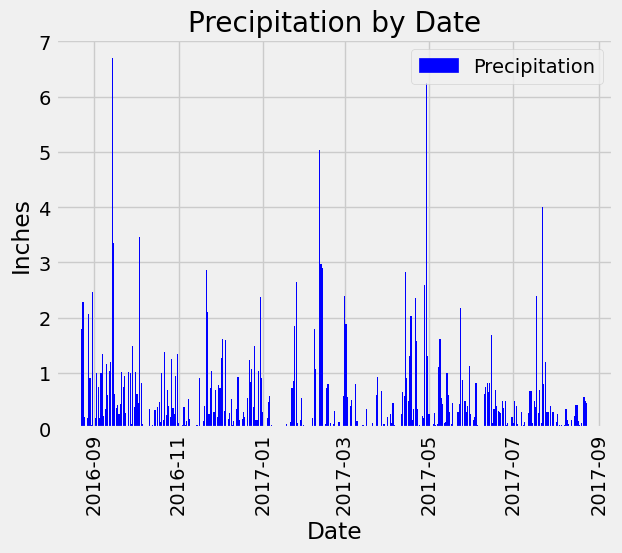

In [91]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(data_df['Date'], data_df['Precipitation'], color='blue')
plt.title("Precipitation by Date")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
colors = {'Precipitation':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

In [92]:
# Use Pandas to calculate the summary statistics for the precipitation data
data_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [93]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).count()
print(station_count)

9


In [94]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station)
                    .order_by(func.count(Measurement.date).desc()).all())
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [95]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = 'USC00519281'
active_station_stats = (session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
                        .filter(Measurement.station == active_station).all())
print(active_station_stats)

[(54.0, 85.0, 71.66378066378067)]


In [96]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Determine the most recent data for this station
most_recent = session.query(Measurement).filter(Measurement.station == active_station).order_by(Measurement.date.desc()).first()

# Convert date string to timestamp
most_recent_str = dt.datetime.strptime(most_recent.date, '%Y-%m-%d')

# Use the datetime utility to subtract one year from this date
year_ago = most_recent_str - dt.timedelta(days = 365)

# Convert the date from one year ago to a string to match those in the data set
year_ago_str = year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve 12 months of tobs (temperature observations)
year_temps = (session.query(Measurement.tobs).filter(Measurement.date >= year_ago_str)
              .filter(Measurement.station == active_station).all())

# Save the query results as a Pandas DataFrame. Explicitly set the column name
temps_df = pd.DataFrame(year_temps)
temps_df.columns = ['Temperature']
temps_df.head()

,Temperature
0,80.0
1,79.0
2,81.0
3,79.0
4,78.0


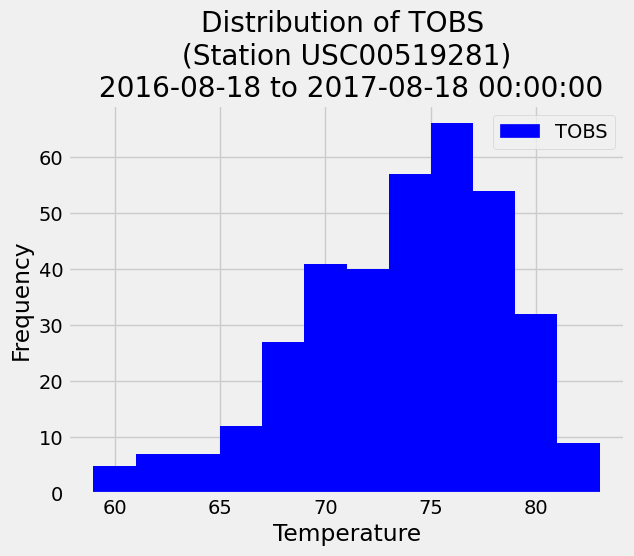

In [97]:
# Plot the last 12 months of temperature observation data for this station as a histogram
plt.hist(temps_df, bins=12, color='blue')
plt.title(f"Distribution of TOBS \n (Station USC00519281) \n {year_ago_str} to {most_recent_str}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
colors = {'TOBS':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

# Close Session

In [98]:
# Close Session
session.close()